## Importing All Required Libraries

In [ ]:
!pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import warnings
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras_tuner import RandomSearch
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline

## Importing Dataset i.e. GOOGLE (GOOGL) Stock Price Dataset

In [ ]:
df = yf.download('GOOGL', start='2004-08-19', end=datetime.today())

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2004-08-19,2.501941,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20,2.700670,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23,2.727849,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24,2.614895,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25,2.643072,2.652653,2.702703,2.599600,2.626627,183772044


In [ ]:
df.tail()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,,
2024-12-26,195.600006,195.600006,196.750000,194.380005,195.149994,12046600
2024-12-27,192.759995,192.759995,195.320007,190.649994,194.949997,18891400
2024-12-30,191.240005,191.240005,192.550003,189.119995,189.800003,14264700
2024-12-31,189.300003,189.300003,191.960007,188.509995,191.080002,17466900
2025-01-02,189.429993,189.429993,192.000000,187.500000,190.649994,20339500


### Dropping the multilevel columns names

In [ ]:
df.columns = df.columns.get_level_values(0)

In [ ]:
df

Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2004-08-19,2.501941,2.511011,2.604104,2.401401,2.502503,893181924
2004-08-20,2.700670,2.710460,2.729730,2.515015,2.527778,456686856
2004-08-23,2.727849,2.737738,2.839840,2.728979,2.771522,365122512
2004-08-24,2.614895,2.624374,2.792793,2.591842,2.783784,304946748
2004-08-25,2.643072,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...,...
2024-12-26,195.600006,195.600006,196.750000,194.380005,195.149994,12046600
2024-12-27,192.759995,192.759995,195.320007,190.649994,194.949997,18891400
2024-12-30,191.240005,191.240005,192.550003,189.119995,189.800003,14264700


In [ ]:
df.duplicated().sum()

0

## Copying the dataset for future use

In [ ]:
df1 = df.copy()
df1.reset_index(inplace=True)

In [ ]:
df.reset_index(drop=True, inplace=True)

### Dropping unwanted column

In [ ]:
df.drop(['Adj Close'], axis=1, inplace=True)

In [ ]:
df

Price,Close,High,Low,Open,Volume
0,2.511011,2.604104,2.401401,2.502503,893181924
1,2.710460,2.729730,2.515015,2.527778,456686856
2,2.737738,2.839840,2.728979,2.771522,365122512
3,2.624374,2.792793,2.591842,2.783784,304946748
4,2.652653,2.702703,2.599600,2.626627,183772044
...,...,...,...,...,...
5123,195.600006,196.750000,194.380005,195.149994,12046600
5124,192.759995,195.320007,190.649994,194.949997,18891400
5125,191.240005,192.550003,189.119995,189.800003,14264700
5126,189.300003,191.960007,188.509995,191.080002,17466900


### Splitting into features and target

In [ ]:
features = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

### Scaling the features

In [ ]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scale the features (Open, High, Low, Volume)
scaled_features = scaler_features.fit_transform(features)

# Scale the target (Close)
scaled_target = scaler_target.fit_transform(target)

### Convert to DataFrame to maintain indices

In [ ]:
# Combine the scaled features and scaled target into a new DataFrame
scaled_data = pd.DataFrame(scaled_features, columns=['Open', 'High', 'Low', 'Volume'])
scaled_data['Close'] = scaled_target  # Use the scaled Close values as the target

### Function to create sequences

In [ ]:
sequence_length = 30
X = []
y = []
target_index = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[['Open', 'High', 'Low', 'Volume']].values[i-sequence_length:i])
    y.append(scaled_data['Close'].values[i])
    target_index.append(i)  # store index of each target value

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

### Splitting the data into train and test set

In [ ]:
# Splitting the first 80% data as training set and rest 20% as test set (Sequential Splitting)
X_train, X_test, y_train, y_test = X[:round(X.shape[0]*0.8)], X[round(X.shape[0]*0.8):], y[:round(y.shape[0]*0.8)], y[round(y.shape[0]*0.8):]
_, y_test_indices = target_index[:round(len(target_index)*0.8)], target_index[round(len(target_index)*0.8):]

### Model Building using CNN

In [ ]:
def build_model(hp):
    model = Sequential()

    # Tune the number of units in each LSTM layer
    filter_1 = hp.Int('filters_1', min_value=32, max_value=128, step=32)
    kernel_size_1 = hp.Choice('kernel_size_1', values=[3, 5, 7])
    pool_size_1 = hp.Choice('pool_size_1', values=[2, 3])

    # Tune dropout rate
    dropout_rate = hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)

    # Tune the dense layer units
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # Adding CNN layers
    model.add(Conv1D(filters=filter_1,
                     kernel_size=kernel_size_1,
                     activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(MaxPooling1D(pool_size=pool_size_1))
    model.add(Conv1D(filters=filter_1,
                     kernel_size=kernel_size_1,
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size_1))
    model.add(Flatten())
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                  hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])),
                  loss='mean_squared_error', metrics=['mse', 'mae'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='stock_price_tuning',
    project_name='cnn_stock_price_sequential')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train,
             validation_data=(X_test, y_test),
             epochs=50,
             callbacks=[early_stopping],
             batch_size=32)

Trial 10 Complete [00h 00m 44s]
val_loss: 0.0013457962195388973

Best val_loss So Far: 0.0004330092342570424
Total elapsed time: 00h 07m 42s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
predictions = best_model.predict(X_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [ ]:
y_pred_inv = scaler_target.inverse_transform(predictions)
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
prediction = pd.DataFrame({'Actual': y_test_inv.flatten(), 'Predicted': y_pred_inv.flatten()}, index=y_test_indices)
for a in prediction.index:
    for b in df1.index:
        if a == b:
            prediction['Date'] = df1['Date']
prediction.set_index('Date', inplace=True)
prediction.sort_index(inplace=True)
prediction

,Actual,Predicted
Date,,
2020-12-11,88.739998,90.676743
2020-12-14,87.612999,90.377579
2020-12-15,88.054001,89.471649
2020-12-16,87.859497,88.286636
2020-12-17,87.025497,88.502457
...,...,...
2024-12-26,195.600006,193.614670
2024-12-27,192.759995,196.027863
2024-12-30,191.240005,196.304138


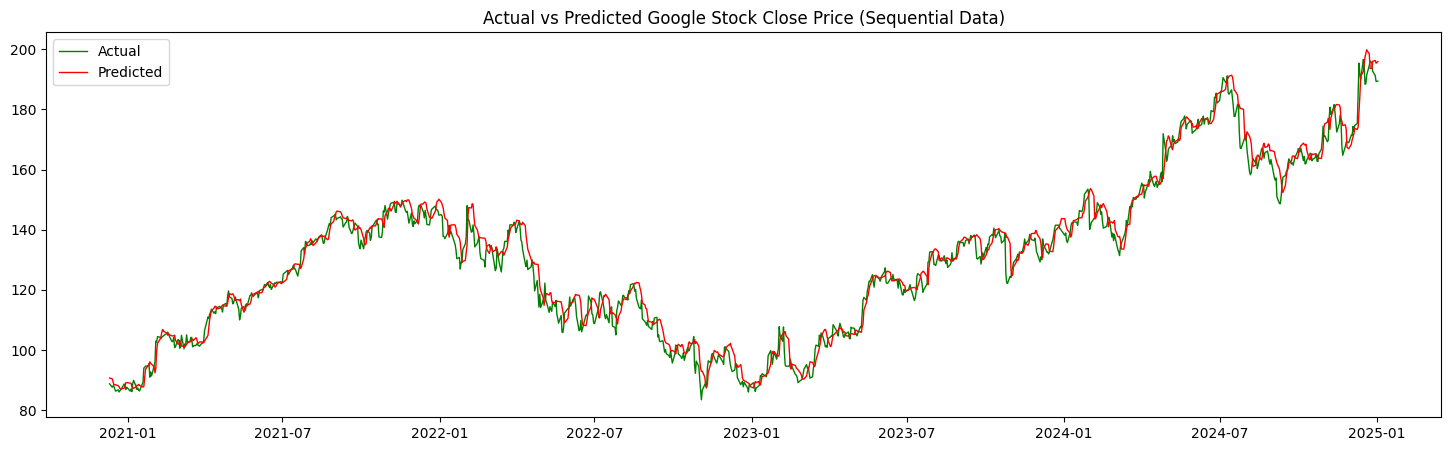

In [ ]:
plt.figure(figsize=(18, 5))
plt.plot(prediction.Actual, label='Actual', color='g', linewidth=1)
plt.plot(prediction.Predicted, label='Predicted', color='r', linewidth=1)
plt.title('Actual vs Predicted Google Stock Close Price (Sequential Data)')
plt.legend()
plt.show()


## Calculating the Performance Evaluation Metrics

In [ ]:
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 0.00041639593597976566
Root Mean Squared Error: 0.020405781925223195
Mean Absolute Error: 0.01500754528642002


In [ ]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('Mean Absolute Error:', mae)

Mean Squared Error: 15.696892434322132
Root Mean Squared Error: 3.9619303924125338
Mean Absolute Error: 2.9138235727945965


In [ ]:
best_model.save('/content/drive/MyDrive/MSc. Dissertation/Model/built_models/cnn_model_sequential_split.h5')